In [1]:
import numpy as np
import matplotlib.pyplot as plt

from xsigmamodules.Util import (
    blackScholes,
    implied_volatility_enum,
)
from xsigmamodules.Market import volatilityModelExtendedSvi
from xsigmamodules.util.misc import xsigmaGetDataRoot
from xsigmamodules.util.numpy_support import numpyToXsigma

%matplotlib inline
XSIGMA_DATA_ROOT = xsigmaGetDataRoot()

# Analytical Sigma Volatility

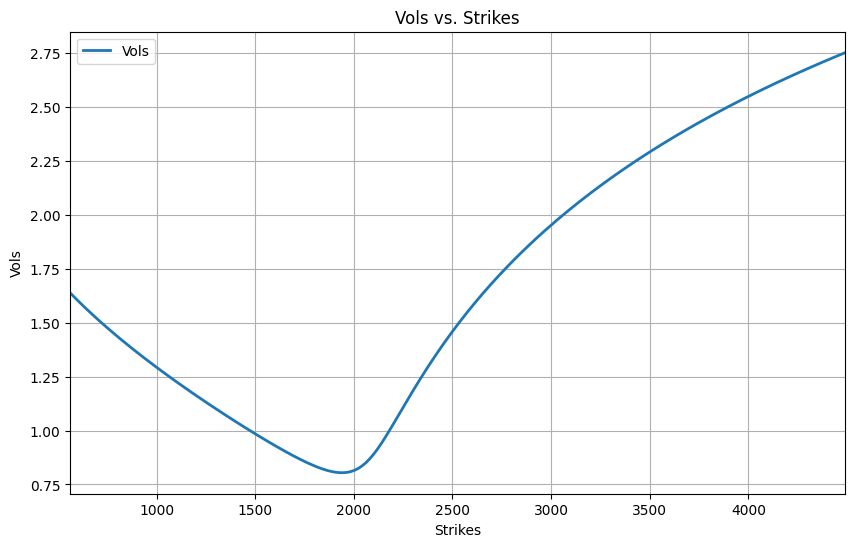

In [2]:
n = 200
fwd = 2245.0656707892695
time = 1.0
ctrl_p = 0.2
ctrl_c = 0.2
atm = 1.1
skew = 3.5
smile = 17
put = 0.7
call = 0.06

# first_half = np.linspace(0.2, 1.0, n // 2, endpoint=False)
# second_half = np.linspace(1.0, 5.0, n // 2, endpoint=True)
# Concatenate the two halves
# strikes_ = np.concatenate((first_half, second_half))
strikes_ = np.linspace(0.25 * fwd, 2.0 * fwd, n)
vols_ = np.zeros(n)
vols0_ = np.zeros(n)
vols0_.fill(atm)
vols_origin = np.zeros(n)

obj = volatilityModelExtendedSvi(fwd, ctrl_p, ctrl_c, atm, skew, smile, put, call)

obj.implied_volatility(
    numpyToXsigma(vols_),
    numpyToXsigma(strikes_),
    fwd,
    time,
    implied_volatility_enum.LOG_NORMAL,
)

plt.figure(figsize=(10, 6))
plt.plot(strikes_, vols_, label="Vols", linewidth=2)
plt.xlabel("Strikes")
plt.ylabel("Vols")
plt.title("Vols vs. Strikes")
plt.legend()
plt.grid(True)
plt.xlim(strikes_[0], strikes_[-1])
plt.show()

In [3]:
fwd = 1.0
time = 0.333
ctrl_p = 0.2
ctrl_c = 0.2
atm = 0.1929
skew = 0.02268
smile = 0.00317
put = -0.00213
call = -0.00006

In [4]:
strikes = np.linspace(0.3, 2.0, n)
vols_minus = np.zeros(n)
vols_plus = np.zeros(n)

obj1 = volatilityModelExtendedSvi(fwd, ctrl_p, ctrl_c, atm, skew, smile, put, call)
obj1.implied_volatility(
    numpyToXsigma(vols_plus),
    numpyToXsigma(strikes),
    fwd,
    time,
    implied_volatility_enum.LOG_NORMAL,
)

obj2 = volatilityModelExtendedSvi(fwd, ctrl_p, 4.0, atm, skew, smile, put, call)
obj2.implied_volatility(
    numpyToXsigma(vols_minus),
    numpyToXsigma(strikes),
    fwd,
    time,
    implied_volatility_enum.LOG_NORMAL,
)

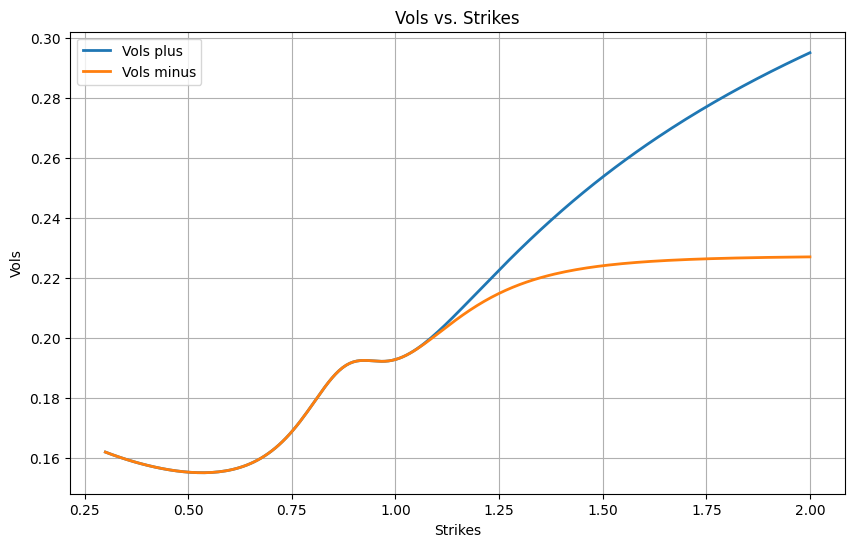

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(strikes, vols_plus, label="Vols plus", linewidth=2)
plt.plot(strikes, vols_minus, label="Vols minus", linewidth=2)
plt.xlabel("Strikes")
plt.ylabel("Vols")
plt.title("Vols vs. Strikes")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
vols = np.zeros(n)
atm_sensitivity = np.zeros(n)
skew_sensitivity = np.zeros(n)
smile_sensitivity = np.zeros(n)
put_sensitivity = np.zeros(n)
call_sensitivity = np.zeros(n)
strike_sensitivity = np.zeros(n)
ref_sensitivity = np.zeros(n)
atm2_sensitivity = np.zeros(n)
ref2_sensitivity = np.zeros(n)
strike2_sensitivity = np.zeros(n)

obj = volatilityModelExtendedSvi(fwd, ctrl_p, ctrl_c, atm, skew, smile, put, call)

obj.sensitivities(
    time,
    numpyToXsigma(strikes),
    numpyToXsigma(vols),
    numpyToXsigma(atm_sensitivity),
    numpyToXsigma(skew_sensitivity),
    numpyToXsigma(smile_sensitivity),
    numpyToXsigma(put_sensitivity),
    numpyToXsigma(call_sensitivity),
    numpyToXsigma(strike_sensitivity),
    numpyToXsigma(ref_sensitivity),
    numpyToXsigma(atm2_sensitivity),
    numpyToXsigma(ref2_sensitivity),
    numpyToXsigma(strike2_sensitivity),
)

In [7]:
density = []  # Initialize an empty list to store the density values
probability = []
for i in range(len(strikes)):
    density_value = blackScholes.density(
        fwd, strikes[i], time, vols[i], strike_sensitivity[i], strike2_sensitivity[i]
    )
    density.append(density_value)
    proba_value = blackScholes.probability(
        fwd, strikes[i], time, vols[i], strike_sensitivity[i]
    )
    probability.append(proba_value)

density = np.array(density)
probability = np.array(probability)

In [8]:
density_bump = []
probability_bump = []
bump = 0.000001

for i in range(len(strikes)):
    strikes_tmp = np.array([strikes[i] - bump, strikes[i], strikes[i] + bump])
    vols_tmp = np.zeros(3)
    obj = volatilityModelExtendedSvi(
        fwd,
        ctrl_p,
        ctrl_c,
        atm,
        skew,
        smile,
        put,
        call,
    )
    obj.implied_volatility(
        numpyToXsigma(vols_tmp),
        numpyToXsigma(strikes_tmp),
        fwd,
        time,
        implied_volatility_enum.LOG_NORMAL,
    )

    value_down = blackScholes.price(fwd, strikes[i] - bump, time, vols_tmp[0], 1.0, 1.0)
    value = blackScholes.price(fwd, strikes[i], time, vols_tmp[1], 1.0, 1.0)
    value_up = blackScholes.price(fwd, strikes[i] + bump, time, vols_tmp[2], 1.0, 1.0)

    density_bump.append((value_up + value_down - 2 * value) / (bump * bump))
    probability_bump.append(1 + (value_up - value_down) / (2.0 * bump))

density_bump = np.array(density_bump)
probability_bump = np.array(probability_bump)

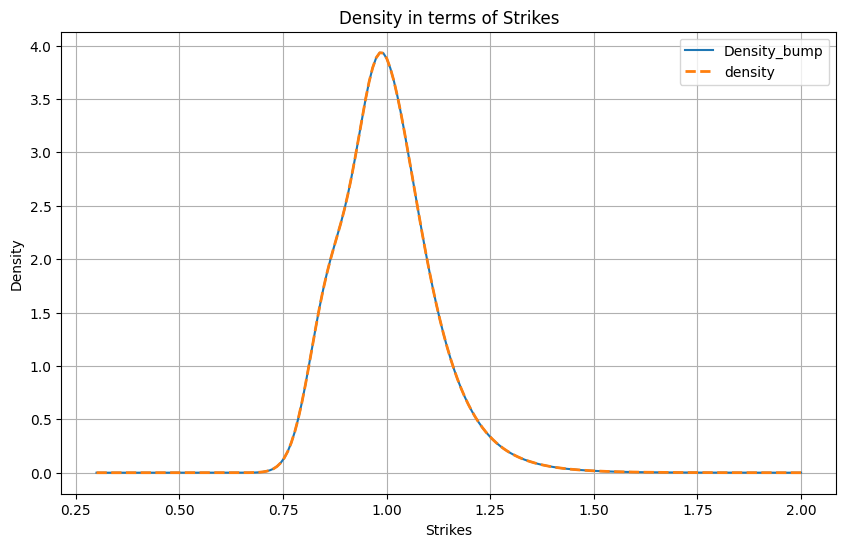

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(strikes, density_bump, label="Density_bump")
plt.plot(
    strikes,
    density,
    label="density",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Strikes")
plt.ylabel("Density")
plt.title("Density in terms of Strikes")
plt.legend()
plt.grid(True)
plt.show()

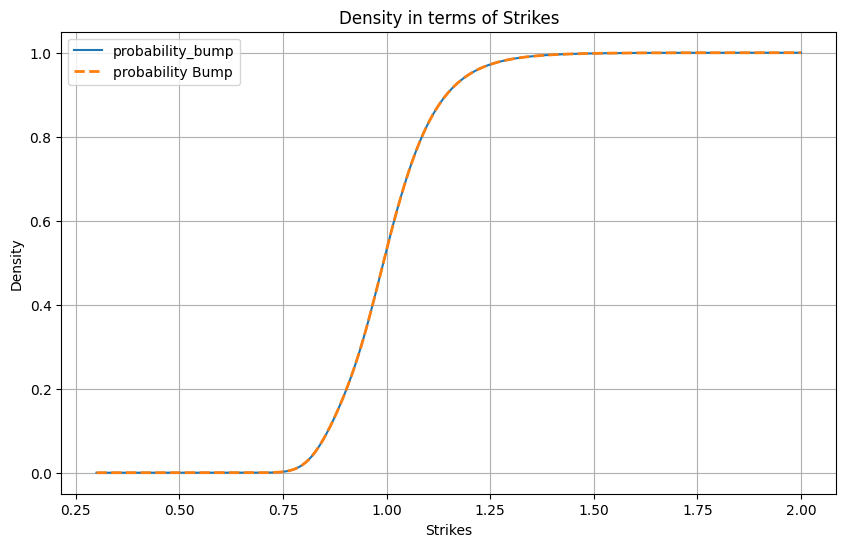

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(strikes, probability_bump, label="probability_bump")
plt.plot(
    strikes,
    probability,
    label="probability Bump",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Strikes")
plt.ylabel("Density")
plt.title("Density in terms of Strikes")
plt.legend()
plt.grid(True)
plt.show()